# 第8章 提升方法

# Boost

“装袋”（bagging）和“提升”（boost）是构建组合模型的两种最主要的方法，所谓的组合模型是由多个基本模型构成的模型，组合模型的预测效果往往比任意一个基本模型的效果都要好。

- 装袋：每个基本模型由从总体样本中随机抽样得到的不同数据集进行训练得到，通过重抽样得到不同训练数据集的过程称为装袋。

- 提升：每个基本模型训练时的数据集采用不同权重，针对上一个基本模型分类错误的样本增加权重，使得新的模型重点关注误分类样本

### AdaBoost

AdaBoost是AdaptiveBoost的缩写，表明该算法是具有适应性的提升算法。

算法的步骤如下：

1）给每个训练样本（$x_{1},x_{2},….,x_{N}$）分配权重，初始权重$w_{1}$均为1/N。

2）针对带有权值的样本进行训练，得到模型$G_m$（初始模型为G1）。

3）计算模型$G_m$的误分率$e_m=\sum_{i=1}^Nw_iI(y_i\not= G_m(x_i))$

4）计算模型$G_m$的系数$\alpha_m=0.5\log[(1-e_m)/e_m]$

5）根据误分率e和当前权重向量$w_m$更新权重向量$w_{m+1}$。

6）计算组合模型$f(x)=\sum_{m=1}^M\alpha_mG_m(x_i)$的误分率。

7）当组合模型的误分率或迭代次数低于一定阈值，停止迭代；否则，回到步骤2）

In [0]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection  import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# data
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]])
    for i in range(len(data)):
        if data[i,-1] == 0:
            data[i,-1] = -1
    # print(data)
    return data[:,:2], data[:,-1]

In [0]:
X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

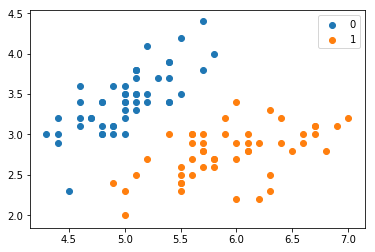

In [8]:
plt.scatter(X[:50,0],X[:50,1], label='0')
plt.scatter(X[50:,0],X[50:,1], label='1')
plt.legend()

In [0]:
# weak classifier
weak_cla = DecisionTreeClassifier(max_depth=1)

In [46]:
# fit
weak_cla.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [47]:
weak_cla_accuracy = weak_cla.score(X_test, y_test);weak_cla_accuracy

0.85

----

### AdaBoost
算法 8.1

In [0]:
class AdaBoost:
    def __init__(self, n_estimators=100):
        self.clf_num = n_estimators
    
    def init_args(self, X, y):
        
        self.X = X
        self.y = y
        M, _ = X.shape
        
        self.models = []
        self.alphas = []
        self.weights = np.ones(M) / M # 1
    
    def fit(self, X, y):
        self.init_args(X, y)
        
        for n in range(self.clf_num):
            cla = DecisionTreeClassifier(max_depth=1) # weak cla
            cla.fit(X, y, sample_weight=self.weights) # 2(a)
            P = cla.predict(X) 
            
            err = self.weights.dot(P != y) # 2(b) 8.1
            alpha = 0.5*(np.log(1 - err) - np.log(err)) # 2(c) 8.2
            
            self.weights = self.weights * np.exp(-alpha * y * P)
            self.weights = self.weights / self.weights.sum() # 2(d) 8.3, 8.4, 8.5
            
            self.models.append(cla)
            self.alphas.append(alpha)
            
        return 'Done!'
    
    def predict(self, x):
        N, _ = x.shape
        FX = np.zeros(N)
        
        for alpha, cla in zip(self.alphas, self.models):
            FX += alpha * cla.predict(x)

        return np.sign(FX)
    
    def score(self, X_test, y_test):
        p = self.predict(X_test)
        r = np.sum(p == y_test)
        
        return r/len(X_test)
    
    def _weights(self):
        return self.alphas, self.weights, self.models

In [0]:
adaboost = AdaBoost()

In [112]:
adaboost.fit(X_train, y_train)

'Done!'

In [113]:
adaboost.score(X_test, y_test)

1.0

### 例8.1

In [0]:
X_ = np.arange(10).reshape(10, 1)
y_ = np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])

In [115]:
clf = AdaBoost()
clf.fit(X_, y_)

'Done!'

-----
# sklearn.ensemble.AdaBoostClassifier

- algorithm：这个参数只有AdaBoostClassifier有。主要原因是scikit-learn实现了两种Adaboost分类算法，SAMME和SAMME.R。两者的主要区别是弱学习器权重的度量，SAMME使用了和我们的原理篇里二元分类Adaboost算法的扩展，即用对样本集分类效果作为弱学习器权重，而SAMME.R使用了对样本集分类的预测概率大小来作为弱学习器权重。由于SAMME.R使用了概率度量的连续值，迭代一般比SAMME快，因此AdaBoostClassifier的默认算法algorithm的值也是SAMME.R。我们一般使用默认的SAMME.R就够了，但是要注意的是使用了SAMME.R， 则弱分类学习器参数base_estimator必须限制使用支持概率预测的分类器。SAMME算法则没有这个限制。

- n_estimators： AdaBoostClassifier和AdaBoostRegressor都有，就是我们的弱学习器的最大迭代次数，或者说最大的弱学习器的个数。一般来说n_estimators太小，容易欠拟合，n_estimators太大，又容易过拟合，一般选择一个适中的数值。默认是50。在实际调参的过程中，我们常常将n_estimators和下面介绍的参数learning_rate一起考虑。

-  learning_rate:  AdaBoostClassifier和AdaBoostRegressor都有，即每个弱学习器的权重缩减系数ν

- base_estimator：AdaBoostClassifier和AdaBoostRegressor都有，即我们的弱分类学习器或者弱回归学习器。理论上可以选择任何一个分类或者回归学习器，不过需要支持样本权重。我们常用的一般是CART决策树或者神经网络MLP。

In [86]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.5)
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=100, random_state=None)

In [87]:
clf.score(X_test, y_test)

1.0